In [1]:
import openmc
import matplotlib.pyplot as plt
import numpy as np
import openmc_source_plotter
import neutronics_material_maker as nmm
import openmc_source_plotter

In [2]:
#Lupin materials

#lead casing
lead = openmc.Material(name='lead')
lead.add_element('Pb', 1, 'ao')

#aluminium shell
al = openmc.Material(name='aluminium')
al.add_element('Al', 1, 'ao')

#cadmium 
cadmium = openmc.Material(name='cadmium')
cadmium.add_element('Cd', 1, 'ao')

#BF3
bf3 = nmm.Material.from_library('Boron Fluoride (BF3)').openmc_material

#polyethylene
polyethylene = openmc.Material(name='polyethylene')
polyethylene.add_elements_from_formula('C2H4')
polyethylene.set_density('kg/m3',940)

#polyethylene.add_s_alpha_beta('c_H_in_polyethylene')
materials = openmc.Materials([lead, al, cadmium, bf3, polyethylene])
materials.export_to_xml()

In [3]:
#geometry dimensions
cylinder_radius = 0.054
detector_radius = 0.02
outer_cylinder_radius = 0.125

lead_height = 0.141
detector_height = 0.047
cylinder_height = 0.297
big_cd_height = 0.05
small_cd_height = 0.025

lead_thickness = 0.0015
shielding_thickness = 0.0015
cd_thickness = 0.0015
cd_gap = 0.02425

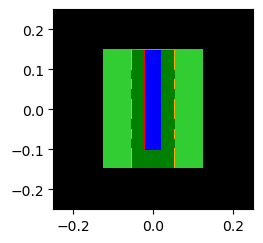

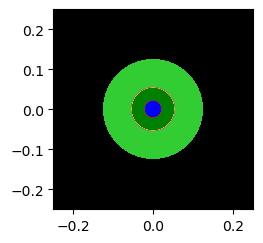

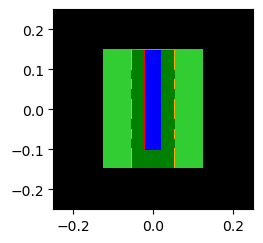

In [4]:
#geometry model

detector = openmc.ZCylinder(r=detector_radius)
shielding = openmc.ZCylinder(r=detector_radius + shielding_thickness)
inner_cylinder = openmc.ZCylinder(r=cylinder_radius)
lead_plate = openmc.ZCylinder(r=cylinder_radius + lead_thickness)
cd_cylinder = openmc.ZCylinder(r=cylinder_radius - (cd_thickness))
outer_cylinder = openmc.ZCylinder(r=outer_cylinder_radius)
source_sphere = openmc.Sphere(r=0.5)
outer_void = openmc.Sphere(r=0.55, boundary_type='vacuum')

top_cylinder = openmc.ZPlane(z0=0.5*cylinder_height)
bottom_cylinder = openmc.ZPlane(z0=-0.5*cylinder_height)
bottom_detector = openmc.ZPlane(z0=-0.5*cylinder_height + detector_height)
bottom_shielding = openmc.ZPlane(z0=-0.5*cylinder_height + detector_height-shielding_thickness)
top_lead = openmc.ZPlane(z0=0.5*lead_height)
bottom_lead = openmc.ZPlane(z0=-0.5*lead_height)
top_wall_cylinder = openmc.ZPlane(z0=0.5*cylinder_height+0.001)

cd_cylinder_region = +cd_cylinder & -inner_cylinder 
cd_bottom_1 = openmc.ZPlane(0.5*cylinder_height-big_cd_height)
cd_top_2 = openmc.ZPlane(0.5*cylinder_height-big_cd_height-cd_gap)
cd_bottom_2 = openmc.ZPlane(0.5*cylinder_height-big_cd_height-cd_gap-small_cd_height)
cd_top_3 = openmc.ZPlane(0.5*cylinder_height-big_cd_height-cd_gap-small_cd_height-cd_gap)
cd_bottom_3 = openmc.ZPlane(0.5*cylinder_height-big_cd_height-cd_gap-small_cd_height-cd_gap-big_cd_height)
cd_top_4 = openmc.ZPlane(0.5*-cylinder_height+big_cd_height+cd_gap+small_cd_height)
cd_bottom_4 = openmc.ZPlane(0.5*-cylinder_height+big_cd_height+cd_gap)
cd_top_5 = openmc.ZPlane(0.5*-cylinder_height+big_cd_height)

cd_1 = cd_cylinder_region & -top_cylinder & +cd_bottom_1
cd_2 = cd_cylinder_region & -cd_top_2 & +cd_bottom_2
cd_3 = cd_cylinder_region & -cd_top_3 & +cd_bottom_3
cd_4 = cd_cylinder_region & -cd_top_4 & +cd_bottom_4
cd_5 = cd_cylinder_region & -cd_top_5 & +bottom_cylinder
cd_region = cd_1 | cd_2 | cd_3 | cd_4 | cd_5

detector_region = -detector & -top_cylinder & +bottom_detector
shielding_region = (-shielding & -top_cylinder & +bottom_shielding & +detector) | ( -detector & +bottom_shielding & -bottom_detector)

#note: used a not to discount cadmium region 
inner_polyethylene_region = ((-inner_cylinder & + shielding & -top_cylinder & +bottom_cylinder) | (-shielding & -bottom_shielding & +bottom_cylinder)) & ~cd_region

lead_region = -lead_plate & -top_lead & +bottom_lead & + inner_cylinder
outer_polyethylene_region = (-outer_cylinder & -top_cylinder & +bottom_cylinder & ~lead_region & +inner_cylinder ) | (-top_wall_cylinder & +top_cylinder & - outer_cylinder)
sphere_region = (-source_sphere & +outer_cylinder) | (+top_wall_cylinder & -source_sphere) | (-bottom_cylinder & -source_sphere)
outer_void_region = +source_sphere & -outer_void

detector_cell = openmc.Cell(region=detector_region, fill=bf3)
shielding_cell = openmc.Cell(region=shielding_region, fill=al)
inner_polyethylene_cell = openmc.Cell(region=inner_polyethylene_region, fill=polyethylene)
lead_cell = openmc.Cell(region=lead_region, fill=lead)
cd_cell = openmc.Cell(region =cd_region, fill = cadmium)
outer_polyethylene_cell = openmc.Cell(region=outer_polyethylene_region, fill=polyethylene)
source_cell = openmc.Cell(region=sphere_region)
outer_void_cell = openmc.Cell(region=outer_void_region)

universe = openmc.universe = openmc.Universe(cells=[detector_cell, shielding_cell, inner_polyethylene_cell, lead_cell, cd_cell, outer_polyethylene_cell, source_cell, outer_void_cell])


x,y = 0.5,0.5
color_assignment = {detector_cell : 'blue',
                    shielding_cell : 'red',
                    inner_polyethylene_cell : 'green',
                    cd_cell : 'orange',
                    lead_cell : 'grey',
                    outer_polyethylene_cell :'limegreen',
                   source_cell : 'black'}
plt.show(universe.plot(width=(x, y), basis='xz',  colors=color_assignment))
plt.show(universe.plot(width=(x, y), basis='xy',  colors=color_assignment))
plt.show(universe.plot(width=(x, y), basis='yz',  colors=color_assignment))

geometry = openmc.Geometry(universe)
geometry.export_to_xml()

In [5]:
#ambe source


In [6]:
#now create the source
#spherical source enclosing the detector
sett = openmc.Settings()
sett.particles = 10000
sett.batches = 5
sett.inactive = 0
sett.run_mode = 'fixed source'

sphere_source = openmc.Source()

phi_angle = openmc.stats.Uniform(a=0., b= 2*3.14159265359)
costheta = openmc.stats.Uniform(a=-1, b= 1)
source_distance = openmc.stats.Discrete([-0.5, 0.5], [0.5,0.5]) #m away from the lupin detector

sphere_source.particle = 'neutron'
sphere_source.energy = openmc.stats.Discrete([14e6],[1])
sphere_source.angle = openmc.stats.Isotropic()
#spherical source at the source cell distance away in all directions
sphere_source.space = openmc.stats.SphericalIndependent(source_distance, costheta, phi_angle, origin=(0.0, 0.0, 0.0))
sett.source = sphere_source


In [7]:
#now create a tally to calibrate the detector
tallies = openmc.Tallies()
neutron_particle_filter = openmc.ParticleFilter(['neutron'])

energy_filter = openmc.EnergyFilter(np.linspace(0,15e6,200))
detector_cell_filter = openmc.CellFilter(detector_cell)
detector_tally = openmc.Tally(name='detector_tally')
detector_tally.scores = ['flux']
detector_tally.filters = [detector_cell_filter, neutron_particle_filter, energy_filter]
tallies.append(detector_tally)


In [8]:
energy_bins_n, dose_coeffs_n = openmc.data.dose_coefficients(particle="neutron", geometry='ISO')

energy_function_filter_n = openmc.EnergyFunctionFilter(energy_bins_n, dose_coeffs_n)

cell_filter = openmc.CellFilter(detector_cell)
dose_tally_neutron = openmc.Tally(name="neutron_energy_dose_cell")
dose_tally_neutron.scores = ["flux"]

dose_tally_neutron.filters = [cell_filter , neutron_particle_filter, energy_function_filter_n]


tallies.append(dose_tally_neutron)

In [9]:
model = openmc.model.Model(geometry, materials, sett, tallies)
# remove old files and runs OpenMC
!rm *.h5
results_filename = model.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

/opt/conda/lib/python3.8/site-packages/openmc/mixin.py:70: IDWarning: Another Filter instance already exists with id=3.
  warn(msg, IDWarning)


 Reading materials XML file...
 Reading geometry XML file...
 Reading Pb204 from /nuclear_data/ENDFB-7.1-NNDC_Pb204.h5
 Reading Pb206 from /nuclear_data/ENDFB-7.1-NNDC_Pb206.h5
 Reading Pb207 from /nuclear_data/ENDFB-7.1-NNDC_Pb207.h5
 Reading Pb208 from /nuclear_data/ENDFB-7.1-NNDC_Pb208.h5
 Reading Al27 from /nuclear_data/ENDFB-7.1-NNDC_Al27.h5
 Reading Cd106 from /nuclear_data/ENDFB-7.1-NNDC_Cd106.h5
 Reading Cd108 from /nuclear_data/ENDFB-7.1-NNDC_Cd108.h5
 Reading Cd110 from /nuclear_data/ENDFB-7.1-NNDC_Cd110.h5
 Reading Cd111 from /nuclear_data/ENDFB-7.1-NNDC_Cd111.h5
 Reading Cd112 from /nuclear_data/ENDFB-7.1-NNDC_Cd112.h5
 Reading Cd113 from /nuclear_data/ENDFB-7.1-NNDC_Cd113.h5
 Reading Cd114 from /nuclear_data/ENDFB-7.1-NNDC_Cd114.h5
 Reading Cd116 from /nuclear_data/ENDFB-7.1-NNDC_Cd116.h5
 Reading B10 from /nuclear_data/ENDFB-7.1-NNDC_B10.h5
 Reading B11 from /nuclear_data/ENDFB-7.1-NNDC_B11.h5
 Reading F19 from /nuclear_data/ENDFB-7.1-NNDC_F19.h5
 Reading C12 from /nuclea

In [10]:
results = openmc.StatePoint(results_filename)

#extracts the tally values from the simulation results
cell_tally = results.get_tally(name='detector_tally')
df = cell_tally.get_pandas_dataframe()
df


,cell,particle,energy low [eV],energy high [eV],nuclide,score,mean,std. dev.
0,1,neutron,0.000000e+00,7.537688e+04,total,flux,0.0,0.0
1,1,neutron,7.537688e+04,1.507538e+05,total,flux,0.0,0.0
2,1,neutron,1.507538e+05,2.261307e+05,total,flux,0.0,0.0
3,1,neutron,2.261307e+05,3.015075e+05,total,flux,0.0,0.0
4,1,neutron,3.015075e+05,3.768844e+05,total,flux,0.0,0.0
...,...,...,...,...,...,...,...,...
194,1,neutron,1.462312e+07,1.469849e+07,total,flux,0.0,0.0
195,1,neutron,1.469849e+07,1.477387e+07,total,flux,0.0,0.0
196,1,neutron,1.477387e+07,1.484925e+07,total,flux,0.0,0.0
197,1,neutron,1.484925e+07,1.492462e+07,total,flux,0.0,0.0


In [11]:
n_p_tally = results.get_tally(name='detector_n_p_tally')
df_np = n_p_tally.get_pandas_dataframe()
df_np

LookupError: Unable to get Tally

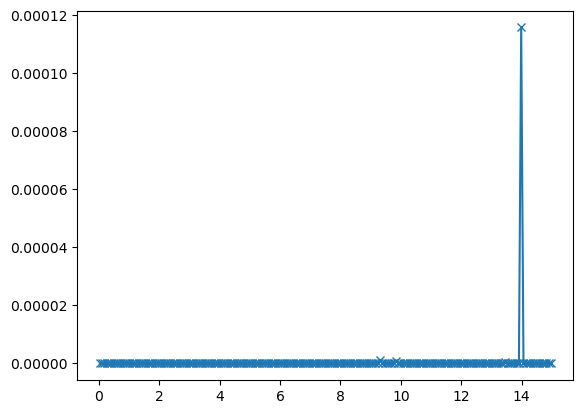

In [12]:
energy_midpoints = (df['energy high [eV]'] + df['energy low [eV]']) /2
curr = cell_tally.mean.ravel()
plt.plot(energy_midpoints/10**6, curr, marker='x')